<h1 align="center">INFO621 - RAG - XAI  - [ OPENAI Models] </h1>



### This notebook / code WORKS Both for Local Macbook & COLAB A100 with a simple toggle `colab_mode=False`.
- Steps are mentioned in README.md.

- If Running Locally in MAC
    - Create virtual Env
        -  run `conda env create -f environments.yaml`
        -  This install all packages and jupyter also
          -  This would create a virtual env named 'ml' 
        - `conda activate ml`
        - `jupyer notebook`
           - ---> and then open this notebook.
        - Set below `colab_mode=False`
        - Change this to your local dir in cell 2  `local_path = '/Users/saurav1/pythonproject/local_models`
        - We suggest running cell by cell manually to see the executions, as some steps are time consuming
     - We expect with very little or no change, the same yaml file can be used in windows. But we have not tested it.
          
- If running in COLAB (recommend using A100)
    - Set below `colab_mode=True`
    - Change if required : `local_path = /content/drive/MyDrive/models`
    - The pip install instructions would create the env in COLAB
    -  **Note : During package install, Colab would ask for "restart" of session. Please do so. And run the install cell again.**
    -  Requires access to your local google drive.


- OpenAI access
  - # Set your key via environment variable --> OPENAI_API_KEY
  - as used in the code
    `os.getenv("OPENAI_API_KEY") = "here"`



### The code here Evaluated Various GPT Models for E2E RAG pipeline
- Refer README.md for more details.
- And the Project report for combined study and analysis
- Models used were **GPT 4.1, 4o, 4.1 mini, 3.5 Turbo**


### Core Libraries used in the project
 - **Core-ML/NLP**: torch, transformers, accelerate, bitsandbytes, sentence-transformers, openai
 - **RAG & Vector Store**: langchain, chromadb, faiss-gpu
 - **Evaluation**: scikit-learn
 - **Data Handling**: datasets, numpy
 - **Utilities**: tqdm, psutil, asyncio, nest_asyncio, openai, tiktoken, matplotlib, seaborn

In [1]:
colab_mode=False

In [2]:
if (colab_mode):
    from google.colab import drive
    drive.mount('/content/drive')
    local_path = "/content/drive/MyDrive/models"
else:
    # Adjust according to your host.
    local_path = '/Users/saurav1/python/masters/arizona/2nd/mlapps621/project/local_models'


In [3]:

# RUN FOR COLAB
if (colab_mode):
  !pip install  langchain==0.3.24
  !pip install  openai
  !pip install  chromadb==1.0.5
  !pip install  scikit-learn
  !pip install  matplotlib
  !pip install  seaborn
  !pip install  datasets==3.5.1
  !pip install langchain-community==0.3.23
  !pip install tiktoken

In [4]:
# #  RUN FOR MACBOOK LOCAL
# conda env create -f environments.yaml


In [5]:

import os
import numpy as np
import re
import warnings
import gc

# Data
from tqdm.notebook import tqdm
from datasets import Dataset, load_dataset

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# LangChain + OpenAI
from langchain.prompts import PromptTemplate

if colab_mode:
  from langchain.chat_models import ChatOpenAI
else:
  from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain.chat_models import ChatOpenAI
from langchain.embeddings import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma
from langchain.chains import RetrievalQA
from langchain_core.retrievers import BaseRetriever
from langchain_core.callbacks import CallbackManager, StdOutCallbackHandler
from collections import Counter

import openai


#  Suppress Warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", message="Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.")

In [6]:
from langchain.callbacks.manager import CallbackManager

# Langchain callback for detailed logging
CALLBACK_VERBOSE_LOGGING=True



## ==== 1) Load FEVER Dataset ====

In [7]:
# dataset1 = load_dataset("fever/feverous")
dataset1 = load_dataset("copenlu/fever_gold_evidence")

In [8]:
dataset1

DatasetDict({
    train: Dataset({
        features: ['claim', 'label', 'evidence', 'id', 'verifiable', 'original_id'],
        num_rows: 228277
    })
    validation: Dataset({
        features: ['claim', 'label', 'evidence', 'id', 'verifiable', 'original_id'],
        num_rows: 15935
    })
    test: Dataset({
        features: ['claim', 'label', 'evidence', 'id', 'verifiable', 'original_id'],
        num_rows: 16039
    })
})

In [9]:
train = dataset1['train']
validation = dataset1['validation']
test = dataset1['test']

## ==== 2) Cleaned FEVER Dataset ====

####  For the preprocessing of the dataset we manage to remove:

- all words after the last dot (they don't belong to the sentence but are a kind of most relevant terms) ------> ?????
- all the digits that we found at the beginning of the sentence (also with the tab)
- all the parenthesis token strings
- all the words that contains characters that are not in ASCII format (for example the ones retrieved by the Wikipedia page for the pronunciation of a given name or term)
- all the punctuation


In [10]:


# Special tokens like "-LRB-" etc.
PARENTHESIS_TOKENS = {"-LRB-", "-LSB-", "-RRB-", "-RSB-"}

# Check for non-ASCII characters
def contains_non_ascii(s):
    return any(ord(ch) > 127 for ch in s)

# Remove parenthesis tokens
def remove_parenthesis(sentence):
    return ' '.join([word for word in sentence.split() if word not in PARENTHESIS_TOKENS])

# Clean up a single sentence
def clean_sentence(sentence):
    if not isinstance(sentence, str):
        return ""

    # 1. Remove trailing fragments after first period (optional)
    sentence = re.sub(r'(\.[^.]*)$', '.', sentence)

    # 2. Remove leading digits + tab
    sentence = re.sub(r'^\d+\t', '', sentence)

    # 3. Remove special parenthesis tokens like -LRB-, -RRB-, etc.
    sentence = re.sub(r'-LRB-|-RRB-|-LSB-|-RSB-', '', sentence)

    # 4. Remove words with non-ASCII characters
    words = sentence.split()
    words = [word for word in words if all(ord(ch) < 128 for ch in word)]
    sentence = ' '.join(words)

    # 5. Remove punctuation and underscores but KEEP dots and commas
    sentence = re.sub(r'[^\w\s.,]', '', sentence)

    # 6. Normalize whitespace
    sentence = re.sub(r'\s+', ' ', sentence)

    sentence = re.sub(r'[^\w\s.,]', '', sentence)
    sentence = re.sub(r'[_]', ' ', sentence)

    # 7. Lowercase
    sentence = sentence.lower().strip()
    if not (sentence.endswith(".")):
        sentence +=  "."
    return sentence

In [11]:
# === Extract and Clean Evidence Sentences ===
def clean_evidences(ds, max_len=500, typ="train"):
    evidence_sentences = []
    total = 0
    for example in ds:
        if 'evidence' in example and example['evidence']:
            total += 1
            for group in example['evidence']:
                full_sent = ""
                for ev in group:
                    if isinstance(ev, str) and not ev.isdigit():
                        sentence = clean_sentence(ev)
                        if sentence:
                            full_sent += sentence + " "
                if full_sent.strip():
                    evidence_sentences.append(full_sent.strip()[0:max_len])
    
    # Deduplicate
    evidence_sentences = list(set(evidence_sentences))
    print("total ", total)
    print(f"Total cleaned evidence dedup sentences : {len(evidence_sentences)}, of {typ}")
    for e in evidence_sentences[:2]:
        print("Sample:", e)
    return evidence_sentences

In [12]:
# # Use only 5,000 for our purpose.
# train_10K=train.select(range(5000))
# train_cl_10K = clean_evidences(train_10K)


In [13]:
# Use 1000 for validation
validation_1K=validation.select(range(1000))
validation_cl_1K = clean_evidences(validation_1K, typ="validation")


total  1000
Total cleaned evidence dedup sentences : 925, of validation
Sample: st. it was the band s last album released through elektra , thus marking the end of the secondlongest timespan between studio albums from metallica , with nearly six years between the release of reload and this album .
Sample: sonequa martingreen. she is to play the lead role in the 2017 series star trek discovery .


In [14]:
# Use 1000 for test
test_1K=test.select(range(1000))
test_cl_1K = clean_evidences(test_1K, typ="test")

total  1000
Total cleaned evidence dedup sentences : 910, of test
Sample: comedytime saturday. with no original programming , comedytime saturday consisted solely of reruns of cbs s monday and thursday night sitcoms how i met your mother , 2 broke girls , two and a half men , mike molly , the big bang theory , or rules of engagement .
Sample: brick mansions. brick mansions is a 2014 englishlanguage frenchcanadian crimethriller film starring paul walker , david belle and rza .


In [31]:
#  Environment setup
import os

# Set it into environment explicitly (ONLY for local use, not in shared code)
os.environ["OPENAI_API_KEY"] = ""  # <-- Replace this with your own !



## === 3. Embedding Model ===

In [16]:
def get_embedding_model(model_name: str = "text-embedding-3-small"):
    """
    Downloads and saves a sentence-transformer model if not already saved.
    Returns a HuggingFaceEmbeddings instance for LangChain.
    
    Args:
        model_name (str): Name of the Hugging Face model.
        save_path (str): Local directory to save/load the model.

    Returns:
        HuggingFaceEmbeddings: Embedding wrapper usable with LangChain retrievers.
    """
    return OpenAIEmbeddings(model=model_name)

In [17]:
embedding_model= get_embedding_model()

## === 4. Chroma Vector Store ===



In [18]:
def monitor_memory():
    mem = psutil.virtual_memory()
    return f"Memory used: {mem.used // (1024**2)} MB / {mem.total // (1024**2)} MB ({mem.percent}%)"

def get_or_create_chroma_db(texts, embedding_model, persist_dir, batch_size=100):
    if os.path.exists(persist_dir):
        print("Loading existing Chroma DB from disk...")
        return Chroma(persist_directory=persist_dir, embedding_function=embedding_model)
    else:
        # return Chroma.from_texts(texts, embedding=embedding_model, persist_directory=persist_dir)
        print("Creating new Chroma DB and saving to disk...")
        print("given size ", len(texts))
        os.makedirs(persist_dir, exist_ok=True)

        # Create Chroma DB (empty)
        vectorstore = Chroma(embedding_function=embedding_model, persist_directory=persist_dir)
    
        for i in tqdm(range(0, len(texts), batch_size), desc="Indexing to Chroma"):
            batch = texts[i:i + batch_size]
            if batch:
                try:
                    vectorstore.add_texts(batch)
                    vectorstore.persist()  # flush to disk
                except Exception as e:
                    print(f"Skipped batch {i}: {e}")
                    raise
            gc.collect()  # clean up memory

        return vectorstore
        

In [19]:
# TRAIN Chroma DB
# evidence_sentences = train_cl_10K
# vectorstore = get_or_create_chroma_db(
#     texts=evidence_sentences,
#     embedding_model=embedding_model,
#     persist_dir=local_path+"/chromadb_fever_train_openai"
# )
# print (len(vectorstore))

In [20]:
# VALIDATE Chroma DB
validation_sentences = validation_cl_1K
vectorstore_validate = get_or_create_chroma_db(
    texts=validation_sentences,
    embedding_model=embedding_model,
    persist_dir=local_path+"/chromadb_fever_validate_openai"
)
print (len(validation_sentences))

Loading existing Chroma DB from disk...
925


##  The OPEN AI model

In [21]:
def load_model(model_id):
    """
    OPEN AI modl_id 
    Returns: model
    """
    model = ChatOpenAI(
        model_name=model_id,
        temperature=0.05,
        openai_api_key=os.environ["OPENAI_API_KEY"],
        streaming=False,
        callback_manager=CallbackManager([StdOutCallbackHandler()])
    )

    return model

### Set Different OPENAI Models

In [22]:
model = load_model(model_id = "gpt-3.5-turbo-0125")
# model = load_model(model_id = "gpt-4o")
# model = load_model(model_id = "gpt-4.1")
# model = load_model(model_id = "gpt-4.1-mini")
llm = model


## === 6. Reasoning Prompt ===

In [23]:
# ULTRA STRICT PROMPT
# Designed to force GPT-4o into cautious, abstaining behavior.
# Forces "NOT ENOUGH INFO" whenever there is any ambiguity.
# Absolutely minimizes hallucinated REFUTES/SUPPORTS.

prompt_template = PromptTemplate(
    input_variables=["context", "question"],
    template="""
You are a fact verification assistant for scientific fact-checking.

Your task:
- Read the provided context carefully.
- Determine whether the claim is SUPPORTED, REFUTED, or if there is NOT ENOUGH INFO to decide.
- You must be extremely cautious:
    - If the context does not fully prove or disprove the claim, answer "NOT ENOUGH INFO".
    - If the context partially matches but lacks full evidence, answer "NOT ENOUGH INFO".
    - If any critical detail is missing or ambiguous, answer "NOT ENOUGH INFO".
    - **Never guess** based on partial clues or your own external knowledge.
    - Do not infer from wording similarity; only based on factual correctness.

Answer strictly in the format:

Final Answer: <SUPPORTS or REFUTES or NOT ENOUGH INFO>

Most Influential Passage: "<quote the exact sentence or phrase from context that most influenced your answer>"

Context:
{context}

Claim:
{question}
""")

# BASIC PROMPT
# prompt_template = PromptTemplate(
#     input_variables=["context", "question"],
#     template="""
# You are a fact-checking assistant.

# Use the retrieved context below to verify the truthfulness of the claim.

# If the claim is fully supported by the context, answer "SUPPORTS".
# If the claim is contradicted by the context, answer "REFUTES".
# If the context does not provide enough information, answer "NOT ENOUGH INFO".

# Be concise. Only output one of the following words: SUPPORTS, REFUTES, NOT ENOUGH INFO.

# Context:
# {context}

# Claim:
# {question}

# Answer:
# """
# )

##  MORE SOPHISTICATED PROMPT

You are a fact verification assistant for scientific fact-checking.

Your task:
- Read the provided context carefully.
- Determine whether the claim is SUPPORTED, REFUTED, or if there is NOT ENOUGH INFO to decide.
- You must be extremely cautious:
    - If the context does not fully prove or disprove the claim, answer "NOT ENOUGH INFO".
    - If the context partially matches but lacks full evidence, answer "NOT ENOUGH INFO".
    - If any critical detail is missing or ambiguous, answer "NOT ENOUGH INFO".
    - **Never guess** based on partial clues or your own external knowledge.
    - Do not infer from wording similarity; only based on factual correctness.

Answer strictly in the format:

Final Answer: < SUPPORTS or REFUTES or NOT ENOUGH INFO >

Most Influential Passage: " < quote the exact sentence or phrase from context that most influenced your answer > "

Context:
{context}

Claim:
{question}

### === 4. MultiQueryRetriever Setup ===



In [24]:
#  retriever 
# retriever = vectorstore.as_retriever(search_kwargs={"k": 5})


In [25]:
# Validate retriever
retriever_validate = vectorstore_validate.as_retriever(search_kwargs={"k": 5})

### We configure Additional RAG pipeline features
- Verbose logging of entire pipeline chain
- MultiQuery retriever which generates multiple queries to Vector DB to improve retrieval
- Threshold based retrieval, so we only pass most relevant documents to generator Model

In [26]:


CUT_OFF = 0.2
def expand_query_claim(claim):
    return [
        claim,
        f"Is it true that {claim}?",
        f"Can you verify if the following claim is accurate: {claim}?"
    ]

def retrieve_with_cutoff(retriever, query, similarity_cutoff=CUT_OFF):
    docs_with_scores = retriever.vectorstore.similarity_search_with_relevance_scores(query, k=5)
    if docs_with_scores and docs_with_scores[0][1] >= similarity_cutoff:
        return [doc for doc, score in docs_with_scores]
    else:
        return []  # Force NOT ENOUGH INFO

from langchain_core.retrievers import BaseRetriever
from typing import Any

class MultiQueryThresholdRetriever(BaseRetriever):
    retriever: Any
    similarity_cutoff: float = CUT_OFF

    def get_relevant_documents(self, query):
        expanded_queries = expand_query_claim(query)
        docs = []
        for q in expanded_queries:
            docs.extend(retrieve_with_cutoff(self.retriever, q, similarity_cutoff=self.similarity_cutoff))
        # Remove duplicates by page_content
        return list({doc.page_content: doc for doc in docs}.values())

threshold_multiquery_retriever_validate = MultiQueryThresholdRetriever(
    retriever=retriever_validate,
    similarity_cutoff=CUT_OFF
)


tagged_rag_chain_validate = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=retriever_validate,
    chain_type="stuff",
    return_source_documents=True,
    chain_type_kwargs={"prompt": prompt_template},
    verbose=False
)


tagged_rag_chain_validate_multiquery = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=threshold_multiquery_retriever_validate,
    chain_type="stuff",
    return_source_documents=True,
    chain_type_kwargs={"prompt": prompt_template},
    verbose=False
)

In [27]:

def extract_label_from_answer_block(text):
    text = text.lower()
    if "support" in text:
        return "SUPPORTS"
    elif "refute" in text:
        return "REFUTES"
    elif "not enough info" in text or "unknown" in text:
        return "NOT ENOUGH INFO"
    else:
        return "UNKNOWN"

## === 7. RAG Chain ===

###  EXECUTION on one Claim

In [28]:
# Run just one sample for explainability
tagged_rag_chain_validate.verbose = True
sample = validation_1K[0]
claim = sample['claim']
result = tagged_rag_chain_validate({"query": claim})
print(result)
# documents = result['source_documents']
# doc_texts = [doc.page_content for doc in documents]
tagged_rag_chain_validate.verbose = False



> Entering new RetrievalQA chain...

> Finished chain.
{'query': 'Jackie (2016 film) was directed by Peter Jackson.', 'result': 'Final Answer: REFUTES\n\nMost Influential Passage: "jackie is a 2016 biographical drama film directed by pablo"', 'source_documents': [Document(page_content='jackie 2016 film. jackie is a 2016 biographical drama film directed by pablo and written by noah oppenheim .'), Document(page_content='jackpot 2013 film. the film released on 13 december 2013 with 1150 screens release in india .'), Document(page_content='baz luhrmann. his 2008 film australia is an epic historical romantic drama film starring hugh jackman and nicole kidman .'), Document(page_content='hush 2016 film. the film was produced by trevor macy , through intrepid pictures , and jason blum through his blumhouse productions banner .'), Document(page_content='hush 2016 film. hush is a 2016 american horror film directed and edited by mike flanagan , starring kate siegel , and written by both .')]}


In [29]:
# print(result['source_documents'])
generated_answers=[result['result']]

In [30]:
pred_label = extract_label_from_answer_block(result["result"])
print("actual=",sample['label'],", predicted=",pred_label)

actual= REFUTES , predicted= REFUTES


# Evaluate GPT MODELS

In [32]:

def evaluate_rag_chain_accuracy(claim_dataset, rag_chain, label_field="label", num_samples=1000):
    true_labels = []
    pred_labels = []

    # samples = claim_dataset.select(range(min(num_samples, len(claim_dataset))))
    for sample in tqdm(claim_dataset.select(range(num_samples)), desc="Evaluating", leave=True):
        claim = sample["claim"]
        true_label = sample[label_field].upper()
        try:
            result = rag_chain({"query": claim})
            model_output = result["result"]
            pred_label = extract_label_from_answer_block(model_output)
        except Exception as e:
            print(f" Error for claim: {claim[:50]}... | {str(e)}")
            pred_label = "UNKNOWN"

        true_labels.append(true_label)
        pred_labels.append(pred_label)

        if CALLBACK_VERBOSE_LOGGING:
            print(f"True: {true_label} | Pred: {pred_label}")

    # Evaluation
    accuracy = accuracy_score(true_labels, pred_labels)
    print(f"\n✅ Accuracy: {accuracy:.4f}")
    print("\n📊 Classification Report:\n", classification_report(true_labels, pred_labels))

    # Confusion matrix
    cm = confusion_matrix(true_labels, pred_labels, labels=["SUPPORTS", "REFUTES", "NOT ENOUGH INFO"])
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=["SUPPORTS", "REFUTES", "NOT ENOUGH INFO"],
                yticklabels=["SUPPORTS", "REFUTES", "NOT ENOUGH INFO"], cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    return pred_labels, true_labels

## GPT 4.1

Evaluating:   0%|          | 0/400 [00:00<?, ?it/s]


✅ Accuracy: 0.7850

📊 Classification Report:
                  precision    recall  f1-score   support

NOT ENOUGH INFO       0.75      0.61      0.67       135
        REFUTES       0.80      0.86      0.83       137
       SUPPORTS       0.80      0.88      0.84       128

       accuracy                           0.79       400
      macro avg       0.78      0.79      0.78       400
   weighted avg       0.78      0.79      0.78       400



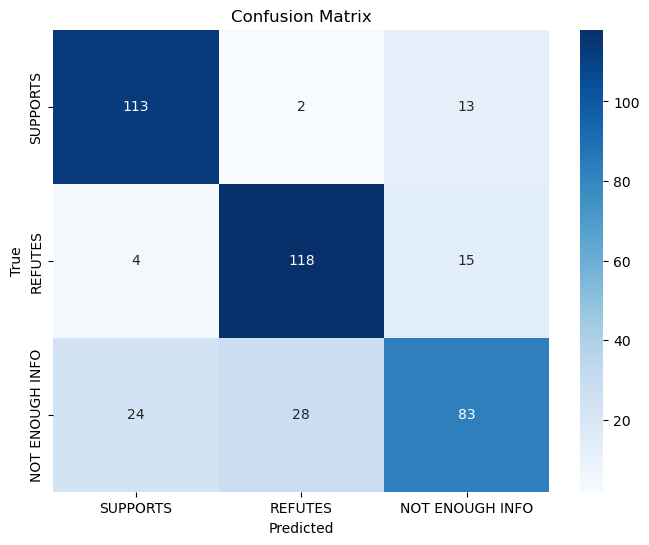

In [33]:


CALLBACK_VERBOSE_LOGGING=False
# Load dataset
ds = validation_1K

# Run evaluation
pred_labels,true_labels = evaluate_rag_chain_accuracy(ds, tagged_rag_chain_validate, num_samples=400)


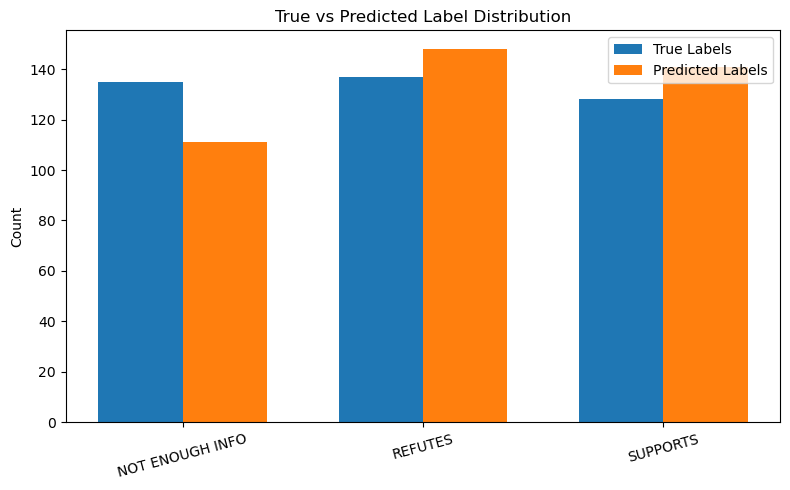

In [34]:
# Count frequencies
true_counts = Counter(true_labels)
pred_counts = Counter(pred_labels)

# Ensure consistent label order
all_labels = sorted(list(set(true_counts.keys()) | set(pred_counts.keys())))

true_values = [true_counts.get(label, 0) for label in all_labels]
pred_values = [pred_counts.get(label, 0) for label in all_labels]

# Bar plot setup
x = np.arange(len(all_labels))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, true_values, width, label="True Labels")
plt.bar(x + width/2, pred_values, width, label="Predicted Labels")

plt.ylabel("Count")
plt.title("True vs Predicted Label Distribution")
plt.xticks(x, all_labels, rotation=15)
plt.legend()
plt.tight_layout()
plt.show()


### Insights for GPT 4.1

- This chart illustrates the true vs. predicted label distribution for the GPT-4.1 model.
- The model slightly underpredicts NOT ENOUGH INFO, while overpredicting REFUTES and SUPPORTS, indicating a bias toward conclusive outputs.
- Despite this, the overall label distribution remains relatively balanced, showing GPT-4.1's strong generalization. 

# Output on 400 samples for other models

### GPT 4o
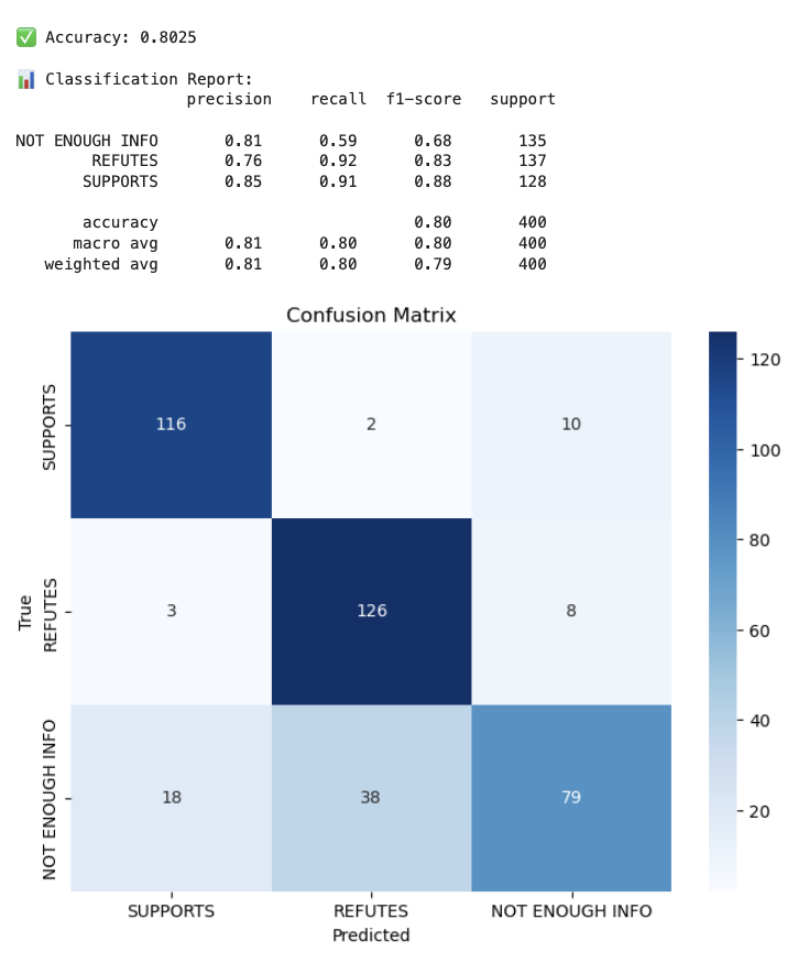


### GPT 4.1 mini
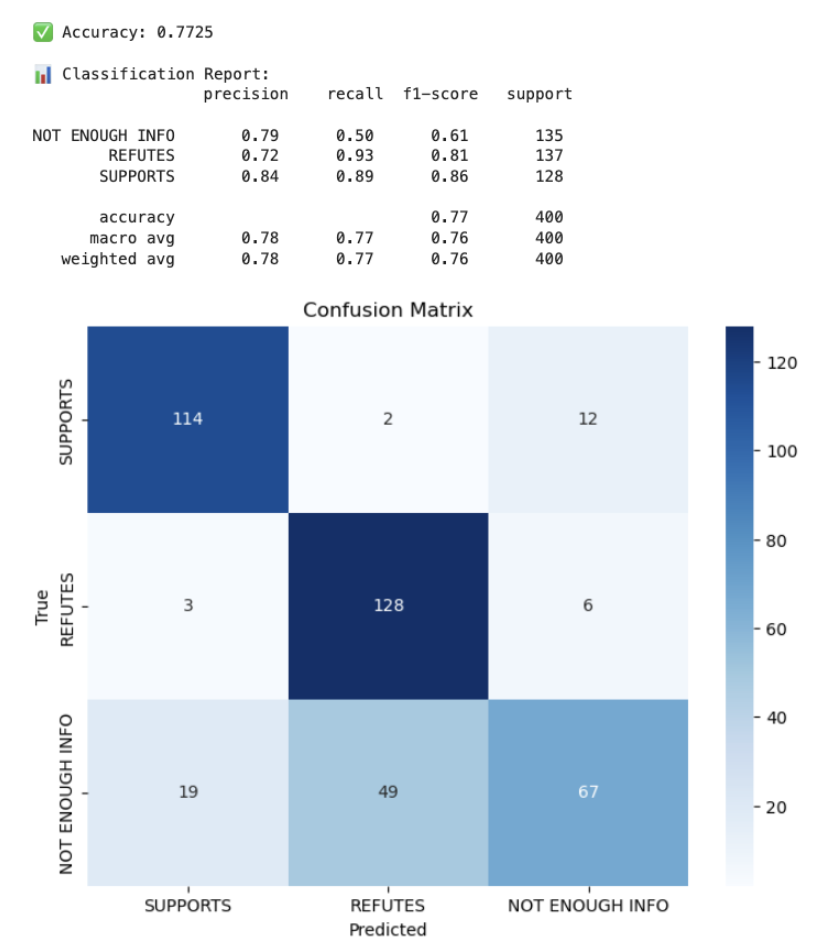

### GPT 3.5 Turbo

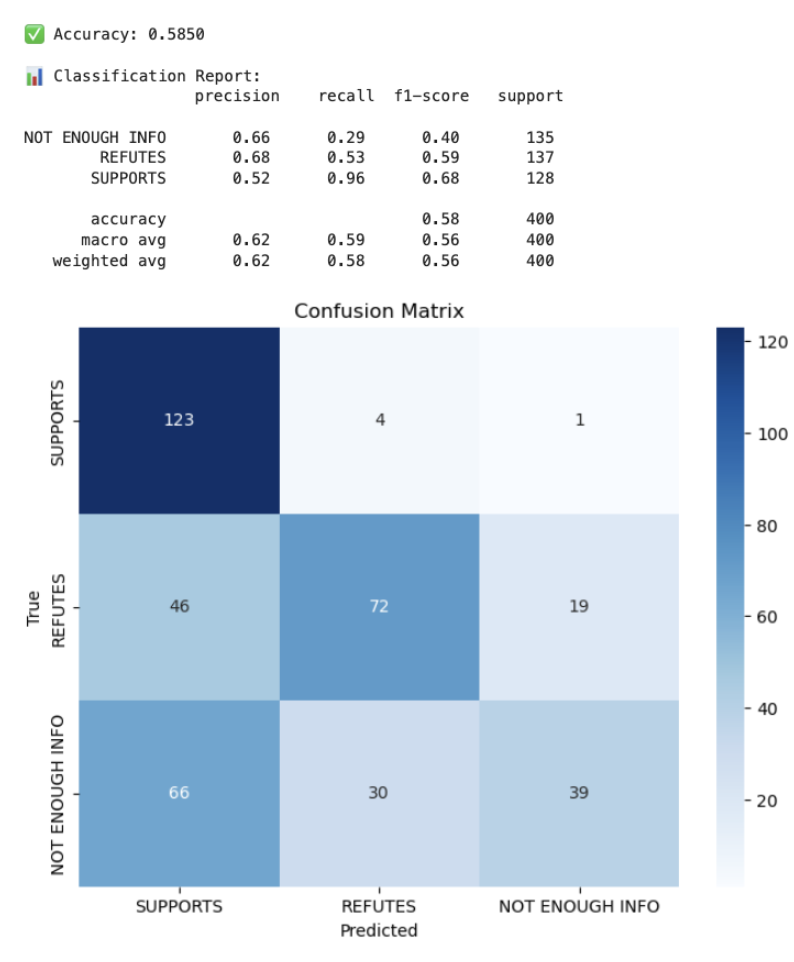

# Ablation Studies

## GPT 4.1 with simple Prompt - Ablation Study 
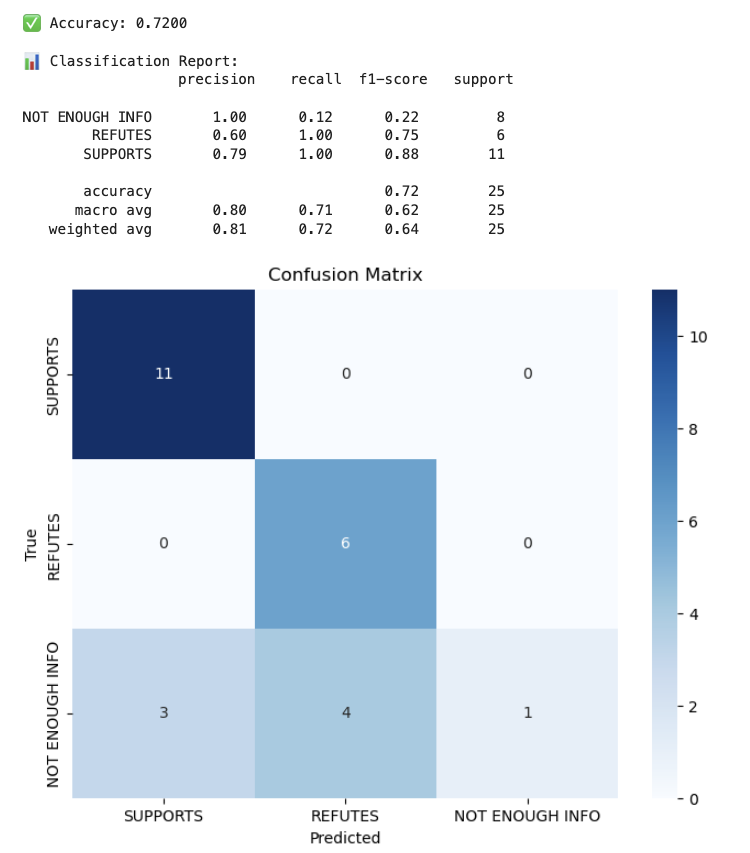

## GPT 4.1 with Strict Prompt - Ablation Study 
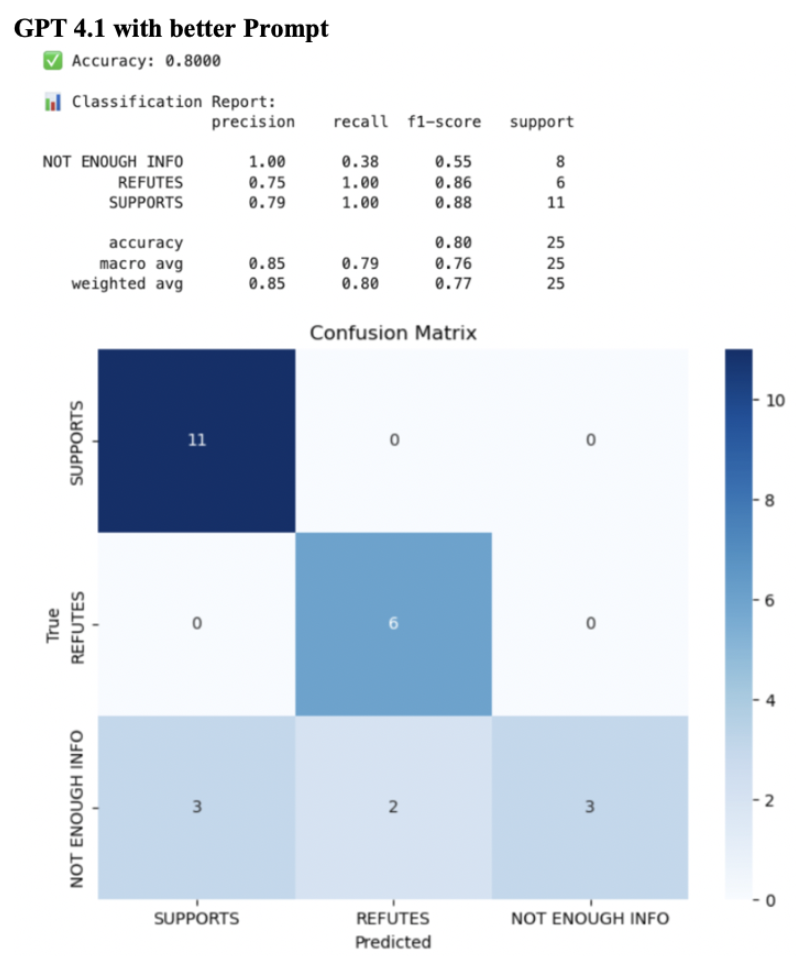

### Insights
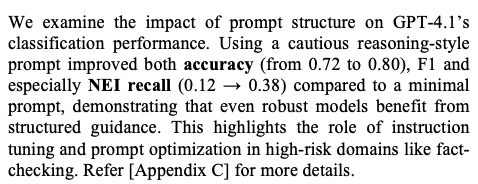

# GPT 3.5 turbo with  MULTI retriever - Ablation study





In [ ]:
CALLBACK_VERBOSE_LOGGING=False
# Load dataset
ds = validation_1K

# Run evaluation
pred_labels,true_labels = evaluate_rag_chain_accuracy(ds, tagged_rag_chain_validate_multiquery, num_samples=10)


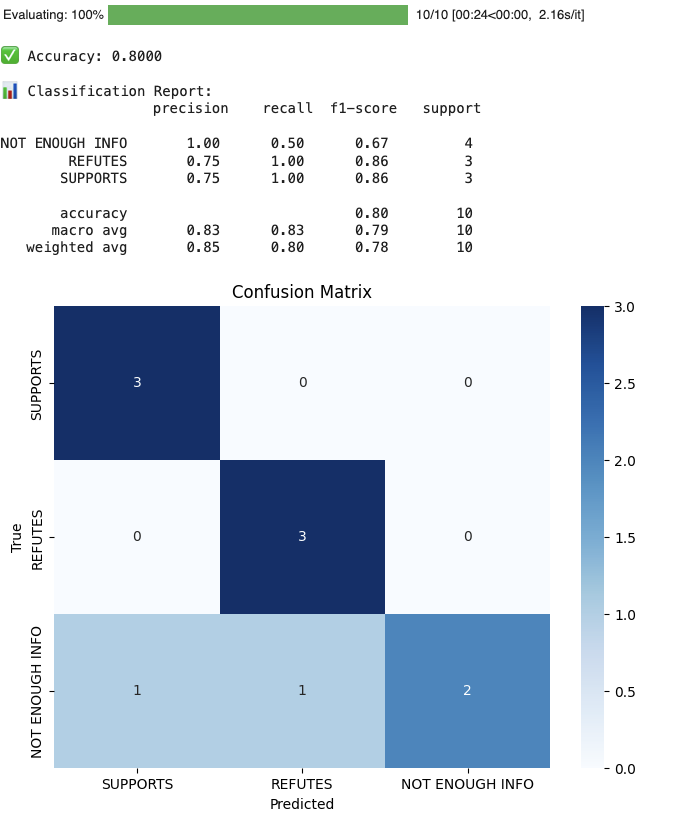

# GPT 3.5 turbo with SINGLE Query retriever - Ablation Study


In [ ]:
CALLBACK_VERBOSE_LOGGING=False
# Load dataset
ds = validation_1K

# Run evaluation
pred_labels,true_labels = evaluate_rag_chain_accuracy(ds, tagged_rag_chain_validate, num_samples=10)


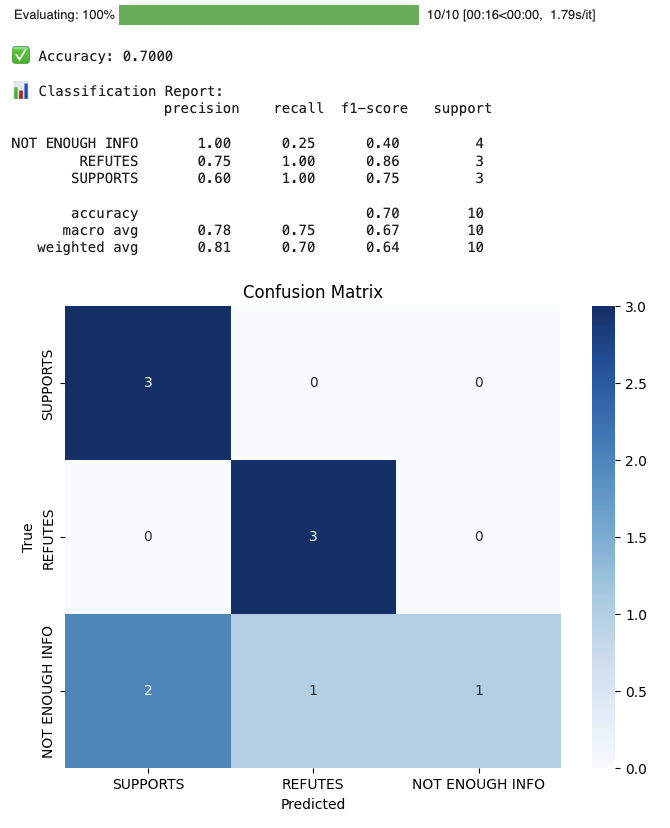

#### Insights
- MultiQurty retriever shows much inproved accuracy and better recall for NEI, thus better class balance